In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

In [56]:
# defining Hovmoller extents
lon1=6.25
lon2=19
lat1=-34
lat2=-13

#----------------------------------------------------------------------------------------------------------------------

# open HYCOMfree dataset and subset
ds_free = xr.open_dataset('../Data/hycom_free_sst.nc')
ds_free = ds_free.sel(time=slice('2009-01-01','2014-06-04'), longitude=slice(lon1,lon2), latitude=slice(lat1,lat2))

# open HYCOMcci dataset, save lats and lons, and subset
ds_cci = xr.open_dataset('../Data/hycom_cci_sst.nc')
cci_lons = ds_cci['latitude']
cci_lats = ds_cci['longitude']
ds_cci = ds_cci.sel(time=slice('2009-01-01','2014-06-04'), longitude=slice(lon1,lon2), latitude=slice(lat1,lat2))

# open SSTcci dataset, convert from kelvin to celsius, assign HYCOM lats and lons, and subset
ds_sst = xr.open_dataset('../Data/cci_bil_regrid.nc')
ds_sst['analysed_sst'] = ds_sst['analysed_sst'] - 273.15
ds_sst['lon'] = cci_lons
ds_sst['lat'] = cci_lats
ds_sst = ds_sst.sel(time=slice('2009-01-01','2014-06-04'), longitude=slice(lon1,lon2), latitude=slice(lat1,lat2))
# ds_sst = ds_sst.transpose('time','latitude','longitude')

#----------------------------------------------------------------------------------------------------------------------

# the following lines are to remove the CCI SST missing days from the model outputs

ds_free_cut_temp1 = ds_free.sel(time=slice('2009-01-01','2011-03-18'))
ds_free_cut_temp2 = ds_free.sel(time=slice('2011-03-24','2014-06-04'))
ds_free = ds_free_cut_temp1.merge(ds_free_cut_temp2)

ds_free_cut_temp1.close()
ds_free_cut_temp2.close()

ds_cci_cut_temp1 = ds_cci.sel(time=slice('2009-01-01','2011-03-18'))
ds_cci_cut_temp2 = ds_cci.sel(time=slice('2011-03-24','2014-06-04'))
ds_cci = ds_cci_cut_temp1.merge(ds_cci_cut_temp2)

ds_cci_cut_temp1.close()
ds_cci_cut_temp2.close()

In [46]:
cci_lats

<xarray.DataArray 'longitude' (longitude: 666)>
array([ 0.      ,  0.090226,  0.180451, ..., 59.81955 , 59.909775, 60.      ],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.09022556 0.18045112 ... 59.909775 60.0
Attributes:
    axis:           X
    standard_name:  longitude
    units:          degrees_east

In [144]:
## create a weekly mean
# ds_cci_mm = ds_cci['temperature'].resample(time="1D").mean(dim="time")
# ds_free_mm = ds_free['temperature'].resample(time="1D").mean(dim="time")
# ds_sst_mm = ds_sst['analysed_sst'].resample(time="1D").mean(dim="time")

# ds_sst_mask = ds_sst['mask'].resample(time="1D").mean(dim="time")

## run the following block for no resampling
ds_cci_mm = ds_cci['temperature']
ds_free_mm = ds_free['temperature']
ds_sst_mm = ds_sst['analysed_sst']

ds_sst_mask = ds_sst['mask']

## Coastline Hovmoller

In [145]:
## choose the number of pixels to extract from coast
npi = 2

## replace all values not == 1 with NAN (i.e. create land mask)
ds_sst_mask2 = ds_sst_mask.where(ds_sst_mask==1)
ds_cci_mask = ds_cci_mm[:,0,:,:].where(ds_cci_mm[:,0,:,:].isnull(), 1)
ds_free_mask = ds_free_mm[:,0,:,:].where(ds_free_mm[:,0,:,:].isnull(), 1)

## sum the masked ocean in order to find the index of the postion of the pixel next to coast (subtract 1 because indexing starts at 0)
index = np.nansum(ds_sst_mask2,2) - 1
index_cci = np.nansum(ds_cci_mask,2) - 1
index_free = np.nansum(ds_free_mask,2) - 1


for idx, val in enumerate(index[0,:]):
    i2 = int(val-npi)
    ds_sst_mask2[:,idx,0:i2] = np.nan
    
for idx, val in enumerate(index_cci[0,:]):
    i2 = int(val-npi)
    ds_cci_mask[:,idx,0:i2] = np.nan
    
for idx, val in enumerate(index_free[0,:]):
    i2 = int(val-npi)
    ds_free_mask[:,idx,0:i2] = np.nan
    
## and use it to create a hovmoller of coastal SST
ds_sst_mm_strip = ds_sst_mm * ds_sst_mask2
ds_sst_mm_hov = np.nanmean(ds_sst_mm_strip,axis=2)

ds_cci_mm_strip = ds_cci_mm * ds_cci_mask
ds_cci_mm_hov = np.nanmean(ds_cci_mm_strip[:,0,:,:],axis=2)

ds_free_mm_strip = ds_free_mm * ds_free_mask
ds_free_mm_hov = np.nanmean(ds_free_mm_strip[:,0,:,:],axis=2)

## create a data array with the hovmoller plot and coords
time_sst = ds_sst_mm['time'].values
lat_sst = ds_sst_mm['latitude'].values

time_cci = ds_cci_mm['time'].values
lat_cci = ds_cci_mm['latitude'].values

time_free = ds_free_mm['time'].values
lat_free = ds_free_mm['latitude'].values

ds_sst_hov = xr.DataArray(ds_sst_mm_hov,dims=['time','latitude'],coords={'time':time_sst,'latitude':lat_sst})
ds_cci_hov = xr.DataArray(ds_cci_mm_hov,dims=['time','latitude'],coords={'time':time_cci,'latitude':lat_cci})
ds_free_hov = xr.DataArray(ds_free_mm_hov,dims=['time','latitude'],coords={'time':time_free,'latitude':lat_free})

/home/harry/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


In [7]:
### calculate the climatology, monthly means and anomalies:
# var1_clim = ds_sst_hov.groupby('time.month').mean('time')
# var1_std = ds_sst_hov.groupby('time.month').std('time')

# var1_anom0 = ds_sst_hov.groupby('time.month') - var1_clim
# var1_anom = var1_anom0.groupby('time.month') / var1_std

### Plotting Hovmoller location

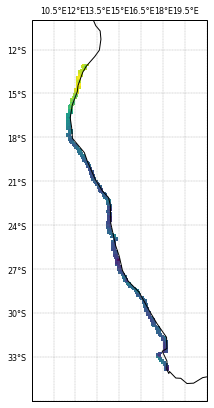

<Figure size 432x288 with 0 Axes>

In [121]:
hov1 = ds_cci_mm_strip[0]

proj = ccrs.PlateCarree()

plt.figure(figsize=(4.5,7))
ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_extent((9, 21, -36, -10))

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = hov1.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
# plt.plot(ds_sst_mm_strip['longitude'], ds_sst_mm_strip['latitude'], ds_sst_mm_strip[:,:,:], ax=ax, transform=ccrs.PlateCarree())
# cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
# cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
ax.set_title('')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/sst/SST_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

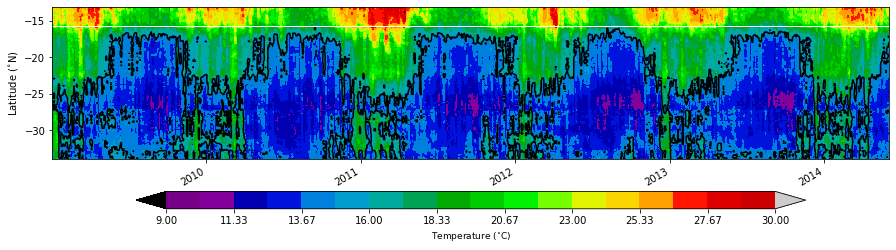

<Figure size 432x288 with 0 Axes>

In [62]:
# plt.figure(figsize=(10,5))
plt.figure(figsize=(15,4))
ax = plt.axes()

# img = ds_sst_hov.plot(x='time', cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False)
img = ds_sst_hov.plot.contourf(x='time',cmap='nipy_spectral', levels=19, add_colorbar=False, vmin=9, vmax=30)
ds_sst_hov.plot.contour(x='time', levels=3, colors='k')
# ds_sst_hov.plot.contour(x='time', levels=[20], add_colorbar=False, colors=['k'])

cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', aspect=35)
cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
ax.set_title('')
plt.ylabel('Latitude ($^{\circ}$N)')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/SST_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

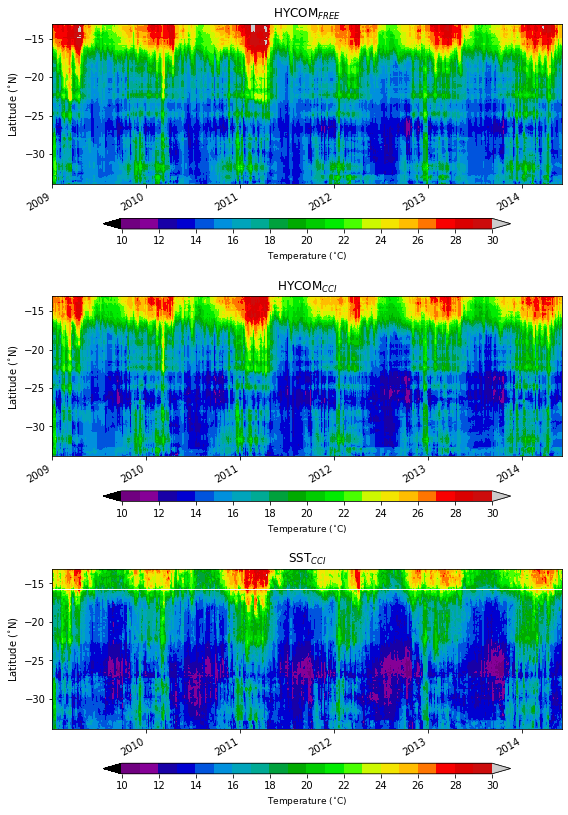

In [146]:
hovs = [ds_free_hov, ds_cci_hov, ds_sst_hov]
names = ['HYCOM$_{FREE}$', 'HYCOM$_{CCI}$', 'SST$_{CCI}$']

fig = plt.figure(figsize=(8,11.5))
# fig.suptitle('Benguela Hovmoller')

cbarticks=np.arange(10,31,1)

for s, i in enumerate(hovs):
    
    ax = plt.subplot(3,1,s+1)
    
    img = i.plot.contourf(x='time', levels=cbarticks, cmap='nipy_spectral', add_colorbar=False, extend='both')
#     contours = i.plot.contour(x='time', levels=cbarticks[::4], linewidths=0.4, colors='k', alpha=0.4)
#     ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
    cbar = plt.colorbar(img, ticks=cbarticks[::2], shrink=0.8, extend='both', orientation='horizontal', aspect=35)
    cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
    ax.set_title('{0}'.format(names[s]))
    plt.ylabel('Latitude ($^{\circ}$N)')
    plt.xlabel('')
    
plt.savefig('../Figures/hovmoller/SST_Benguela_coastline_mean.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

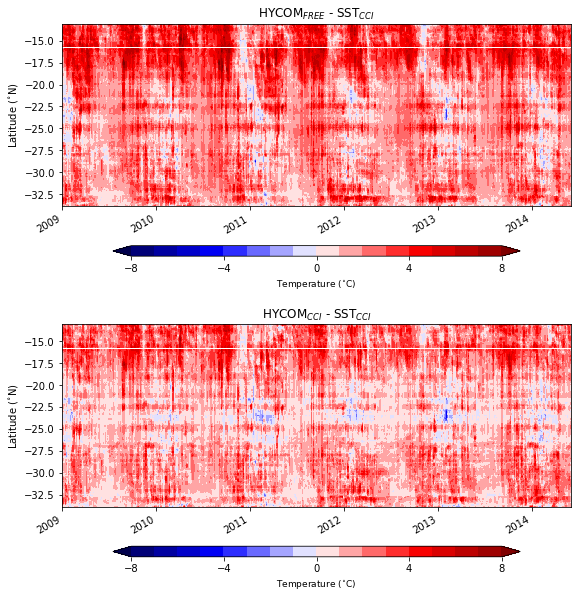

In [101]:
diff_freesst = ds_free_hov.copy()
diff_freesst.values = ds_free_hov.values-ds_sst_hov.values

diff_ccisst = ds_cci_hov.copy()
diff_ccisst.values = ds_cci_hov.values-ds_sst_hov.values

hovs = [diff_freesst, diff_ccisst]
names = ['HYCOM$_{FREE}$ - SST$_{CCI}$', 'HYCOM$_{CCI}$ - SST$_{CCI}$']

fig = plt.figure(figsize=(8,8.5))
# fig.suptitle('Benguela Hovmoller')

cbarticks=np.arange(-8,9,1)

for s, i in enumerate(hovs):
    
    ax = plt.subplot(2,1,s+1)
    
    img = i.plot.contourf(x='time', levels=cbarticks, cmap='seismic', add_colorbar=False, extend='both')
#     contours = i.plot.contour(x='time', levels=cbarticks[::2], linewidths=0.4, colors='k', alpha=0.4)
#     ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
    cbar = plt.colorbar(img, ticks=cbarticks[::4], shrink=0.8, extend='both', orientation='horizontal', aspect=35)
    cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
    ax.set_title('{0}'.format(names[s]))
    plt.ylabel('Latitude ($^{\circ}$N)')
    plt.xlabel('')
    
plt.savefig('../Figures/hovmoller/SST_Benguela_coastline_diffs.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## Offshore Hovmoller

In [124]:
## choose the number of pixels to extract from coast
npi = 2

## replace all values not == 1 with NAN (i.e. create land mask)
ds_sst_mask2 = ds_sst_mask.where(ds_sst_mask==1)
ds_cci_mask = ds_cci_mm[:,0,:,:].where(ds_cci_mm[:,0,:,:].isnull(), 1)
ds_free_mask = ds_free_mm[:,0,:,:].where(ds_free_mm[:,0,:,:].isnull(), 1)

## sum the masked ocean in order to find the index of the postion of the pixel next to coast (subtract 1 because indexing starts at 0)
index = np.nansum(ds_sst_mask2,2) - 1
index_cci = np.nansum(ds_cci_mask,2) - 1
index_free = np.nansum(ds_free_mask,2) - 1


for idx, val in enumerate(index[0,:]):
    i2 = int(val-npi - 50)
    ds_sst_mask2[:,idx,0:i2] = np.nan
    ds_sst_mask2[:,idx,i2+3:-1] = np.nan
    
for idx, val in enumerate(index_cci[0,:]):
    i2 = int(val-npi - 50)
    ds_cci_mask[:,idx,0:i2] = np.nan
    ds_cci_mask[:,idx,i2+3:-1] = np.nan
    
for idx, val in enumerate(index_free[0,:]):
    i2 = int(val-npi - 50)
    ds_free_mask[:,idx,0:i2] = np.nan
    ds_free_mask[:,idx,i2+3:-1] = np.nan
    
## and use it to create a hovmoller of coastal SST
ds_sst_mm_strip = ds_sst_mm * ds_sst_mask2
ds_sst_mm_hov = np.nanmean(ds_sst_mm_strip,axis=2)

ds_cci_mm_strip = ds_cci_mm * ds_cci_mask
ds_cci_mm_hov = np.nanmean(ds_cci_mm_strip[:,0,:,:],axis=2)

ds_free_mm_strip = ds_free_mm * ds_free_mask
ds_free_mm_hov = np.nanmean(ds_free_mm_strip[:,0,:,:],axis=2)

## create a data array with the hovmoller plot and coords
time_sst = ds_sst_mm['time'].values
lat_sst = ds_sst_mm['latitude'].values

time_cci = ds_cci_mm['time'].values
lat_cci = ds_cci_mm['latitude'].values

time_free = ds_free_mm['time'].values
lat_free = ds_free_mm['latitude'].values

ds_sst_hov = xr.DataArray(ds_sst_mm_hov,dims=['time','latitude'],coords={'time':time_sst,'latitude':lat_sst})
ds_cci_hov = xr.DataArray(ds_cci_mm_hov,dims=['time','latitude'],coords={'time':time_cci,'latitude':lat_cci})
ds_free_hov = xr.DataArray(ds_free_mm_hov,dims=['time','latitude'],coords={'time':time_free,'latitude':lat_free})

In [7]:
### calculate the climatology, monthly means and anomalies:
# var1_clim = ds_sst_hov.groupby('time.month').mean('time')
# var1_std = ds_sst_hov.groupby('time.month').std('time')

# var1_anom0 = ds_sst_hov.groupby('time.month') - var1_clim
# var1_anom = var1_anom0.groupby('time.month') / var1_std

### Plotting Hovmoller location

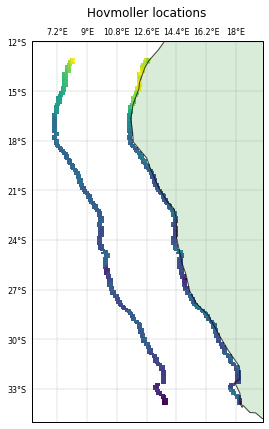

<Figure size 432x288 with 0 Axes>

In [143]:
hov2 = ds_cci_mm_strip[0]
# hov_combined = np.nansum(hov1,hov2)

proj = ccrs.PlateCarree()

plt.figure(figsize=(4.5,7))
ax = plt.axes(projection=proj)
ax.coastlines(alpha=0.7)
ax.add_feature(cartopy.feature.LAND, alpha=0.15, facecolor='green')
# ax.set_extent((9, 21, -36, -10))

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img1 = hov1.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
img2 = hov2.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('Hovmoller locations', y=1.05)
plt.savefig('../Figures/hovmoller/hovmoller_locations.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

In [118]:
hov2

<xarray.DataArray 'temperature' (latitude: 213, longitude: 141)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2009-01-01
  * longitude  (longitude) float32 6.3157897 6.406015 ... 18.857143 18.947369
  * latitude   (latitude) float32 -33.91269 -33.822987 ... -13.174373 -13.069165
    depth      float32 0.0
Attributes:
    units:          Celsius
    standard_name:  sea_water_potential_temperature
    grid_mapping:   mercator
    cell_methods:   area: mean

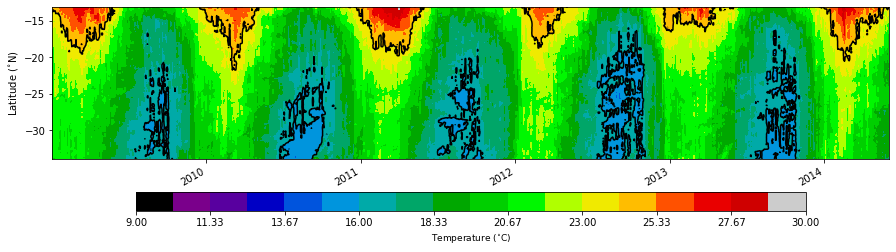

<Figure size 432x288 with 0 Axes>

In [129]:
# plt.figure(figsize=(10,5))
plt.figure(figsize=(15,4))
ax = plt.axes()

# img = ds_sst_hov.plot(x='time', cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False)
img = ds_sst_hov.plot.contourf(x='time',cmap='nipy_spectral', levels=19, add_colorbar=False, vmin=9, vmax=30)
ds_sst_hov.plot.contour(x='time', levels=3, colors='k')
# ds_sst_hov.plot.contour(x='time', levels=[20], add_colorbar=False, colors=['k'])

cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', aspect=35)
cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
ax.set_title('')
plt.ylabel('Latitude ($^{\circ}$N)')
# plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/SST_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

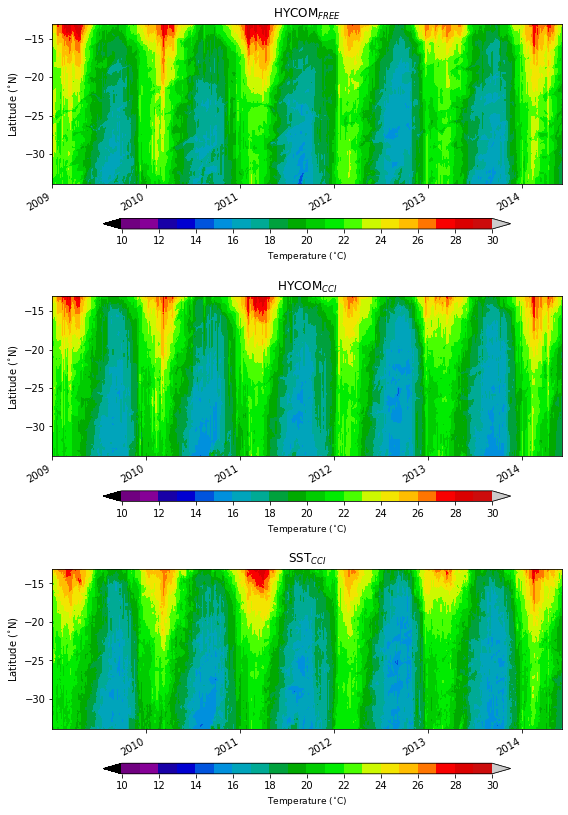

In [130]:
hovs = [ds_free_hov, ds_cci_hov, ds_sst_hov]
names = ['HYCOM$_{FREE}$', 'HYCOM$_{CCI}$', 'SST$_{CCI}$']

fig = plt.figure(figsize=(8,11.5))
# fig.suptitle('Benguela Hovmoller')

cbarticks=np.arange(10,31,1)

for s, i in enumerate(hovs):
    
    ax = plt.subplot(3,1,s+1)
    
    img = i.plot.contourf(x='time', levels=cbarticks, cmap='nipy_spectral', add_colorbar=False, extend='both')
#     contours = i.plot.contour(x='time', levels=cbarticks[::4], linewidths=0.4, colors='k', alpha=0.4)
#     ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
    cbar = plt.colorbar(img, ticks=cbarticks[::2], shrink=0.8, extend='both', orientation='horizontal', aspect=35)
    cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
    ax.set_title('{0}'.format(names[s]))
    plt.ylabel('Latitude ($^{\circ}$N)')
    plt.xlabel('')
    
plt.savefig('../Figures/hovmoller/SST_Benguela_offshore_mean.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

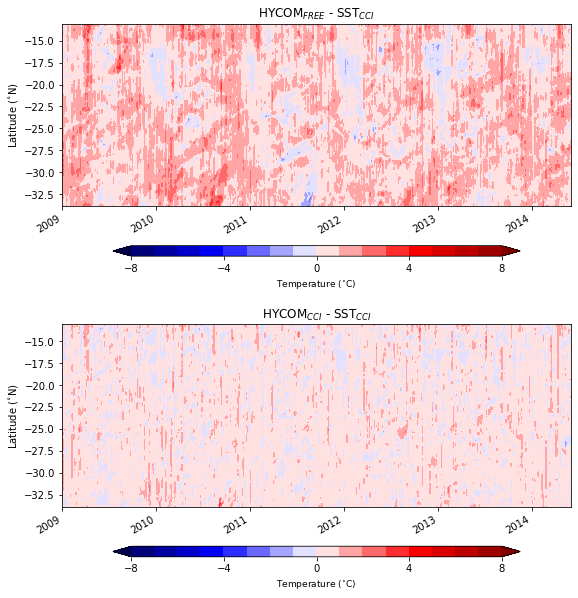

In [132]:
diff_freesst = ds_free_hov.copy()
diff_freesst.values = ds_free_hov.values-ds_sst_hov.values

diff_ccisst = ds_cci_hov.copy()
diff_ccisst.values = ds_cci_hov.values-ds_sst_hov.values

hovs = [diff_freesst, diff_ccisst]
names = ['HYCOM$_{FREE}$ - SST$_{CCI}$', 'HYCOM$_{CCI}$ - SST$_{CCI}$']

fig = plt.figure(figsize=(8,8.5))
# fig.suptitle('Benguela Hovmoller')

cbarticks=np.arange(-8,9,1)

for s, i in enumerate(hovs):
    
    ax = plt.subplot(2,1,s+1)
    
    img = i.plot.contourf(x='time', levels=cbarticks, cmap='seismic', add_colorbar=False, extend='both')
#     contours = i.plot.contour(x='time', levels=cbarticks[::2], linewidths=0.4, colors='k', alpha=0.4)
#     ax.clabel(contours, inline=True, fontsize=6, fmt='%1.0f')
    cbar = plt.colorbar(img, ticks=cbarticks[::4], shrink=0.8, extend='both', orientation='horizontal', aspect=35)
    cbar.set_label('Temperature ($^{\circ}$C)', fontsize=9)
    ax.set_title('{0}'.format(names[s]))
    plt.ylabel('Latitude ($^{\circ}$N)')
    plt.xlabel('')
    
plt.savefig('../Figures/hovmoller/SST_Benguela_offshore_diffs.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()